In [1]:
%pylab inline
import os
import sys
import numpy as np
import scipy.misc
caffeDir = '../caffe/python/'
sys.path.append(caffeDir)
from caffe import *
set_mode_gpu()
set_device(0)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load network weights
net = Net('../models/car_single/deploy.prototxt', 
          '../models/car_single/car_single.caffemodel', 1)

In [3]:
def inference(net, im, tform):
    """Run inference on one image under one transformation.
    Args:
        net: caffe net with loaded weights.
        im: input image in uint8 [height, width, 3]
        tform: one-hot encoding of the desired transformation.
    Returns:
        Resulting image.
    """
    gx, gy = np.meshgrid(range(im.shape[1]), range(im.shape[0]))
    im = np.transpose(im, (2,0,1)).astype(float)
    net.blobs['srcImg'].data[...] = im[None,:,:,:]
    # Last dimension always set to 1 due to legacy reasons
    tform[-1] = 1
    net.blobs['tform'].data[...] = tform[None,:]
    net.forward()
    predMask = np.copy(net.blobs['predMaskSM'].data[0,1] > 0.5).astype(np.float32)
    predImg = np.copy(net.blobs['predImg'].data[0]).transpose((1, 2, 0))
    predImg = (predImg * predMask[:,:,None]).astype(uint8)
    return predImg

Input image


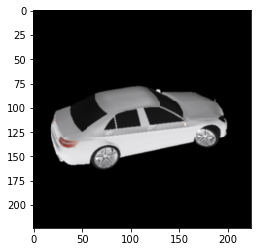

In [4]:
# Load input image
im = scipy.misc.imread('images/1.png')
print("Input image")
figure(); imshow(im)

Synthesized views


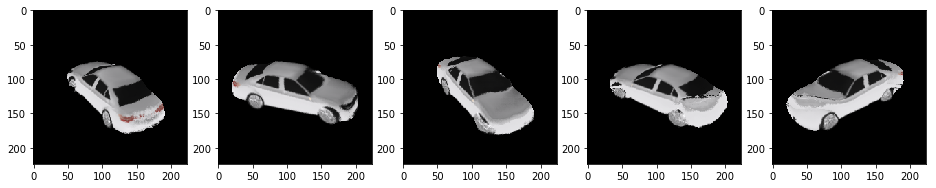

In [39]:
num_tforms = net.blobs['tform'].data.shape[1]
print("Synthesized views")
num_runs = 5
figure(figsize=(16,16)); 
for r in range(num_runs):
    tform = np.zeros((num_tforms))
    # Randomly sample a transformation (one-hot encoding)
    t = np.random.randint(num_tforms)
    tform[t] = 1
    out_im = inference(net, im, tform)
    subplot(1, num_runs, r+1); imshow(out_im)